In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import time

# ANN on MNIST

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root = "../Data", train = True, download = True, transform = transform)

In [5]:
test_data = datasets.MNIST(root = "../Data", train = False, download = True, transform = transform)

In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [9]:
train_data[0][0] #image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [10]:
train_data[0][1] # label

5

In [11]:
image, label = train_data[0]

In [12]:
image.shape # 1-> grayscale image

torch.Size([1, 28, 28])

In [13]:
label

5

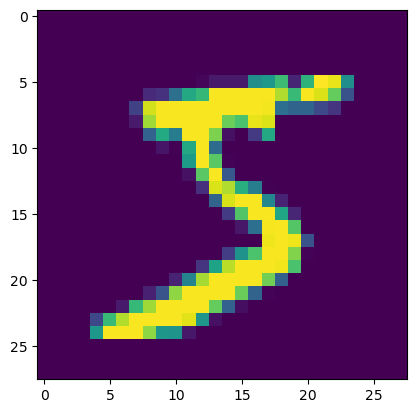

In [14]:
plt.imshow(image.reshape((28,28))) # default colormapping is "viridis"

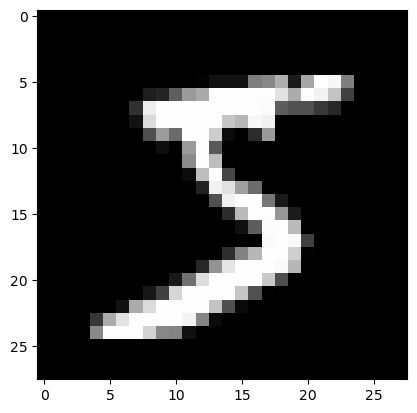

In [15]:
plt.imshow(image.reshape((28,28)), cmap = "gray")

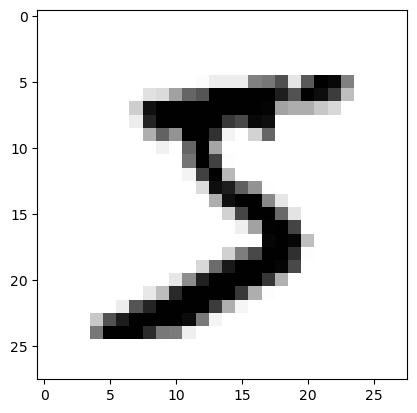

In [16]:
plt.imshow(image.reshape((28,28)), cmap = "gist_yarg") # negative to the above image

In [17]:
torch.manual_seed(53)

train_loader = DataLoader(train_data, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 500, shuffle = False)

In [18]:
np.set_printoptions(formatter = dict(int=lambda x: f"{x: 4}"))

In [19]:
# first batch
for images, labels in train_loader:
    break

In [20]:
images.shape, labels.shape # the number of images and labels is equal to the batch size

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [21]:
print('Labels: ', labels[:10].numpy()) # printing the first ten labels

Labels:  [   9    7    1    6    0    1    6    0    7    9]


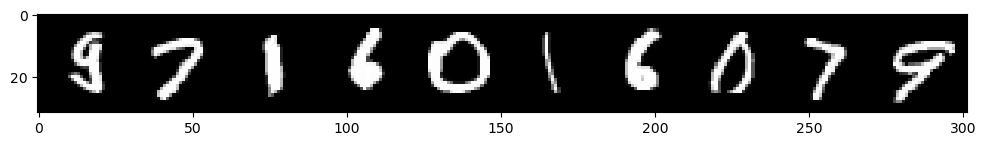

In [22]:
im = make_grid(images[:10], nrow=10)  # the default nrow is 8
plt.figure(figsize=(12,6)) 
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))) # transpose the images from (channel, width, height) to WHC

## __ANN__

In [23]:
class MultilayerPerceptron(nn. Module):
    def __init__(self, input_size = 784, output_size = 10, layers = [120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(input_size, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.log_softmax(self.fc3(X), dim = 1)

        return X

In [24]:
torch.manual_seed(53)

model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [27]:
images.shape

torch.Size([100, 1, 28, 28])

 ---> [100, 784] by using .view

In [28]:
images.view(100, -1).shape

torch.Size([100, 784])

## __Training__

In [30]:
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []

train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.detach(), dim = 1)[1] # values: [0.1, 0.0,..., 0.8]; indices: [0, 1,..., 9] ----> 9
        # dim = 1 ----> the highest probability for each sample in the batch
        # print(y_pred.detach())
        
        batch_correct = (predicted == y_train).sum()
        # print(batch_correct)
        
        train_corr += batch_correct

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 100 == 0:
            accuracy = train_corr.item() * 100 / (100 * b)
            print(f"Epoch: {i}; batch: {b}; loss: {loss.item()}; accuracy: {accuracy:.3f}")
        
    train_losses.append(loss)
    train_correct.append(train_corr)

    with torch.no_grad():
        
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.detach(), 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)


total_time = time.time() - start_time
print(f"Duration: {total_time / 60:.3f} minutes")

Epoch: 0; batch: 100; loss: 0.35879042744636536; accuracy: 76.470
Epoch: 0; batch: 200; loss: 0.32136619091033936; accuracy: 83.025
Epoch: 0; batch: 300; loss: 0.17121189832687378; accuracy: 85.850
Epoch: 0; batch: 400; loss: 0.3657015860080719; accuracy: 87.480
Epoch: 0; batch: 500; loss: 0.18691512942314148; accuracy: 88.678
Epoch: 0; batch: 600; loss: 0.1862039566040039; accuracy: 89.527
Epoch: 1; batch: 100; loss: 0.21774528920650482; accuracy: 94.560
Epoch: 1; batch: 200; loss: 0.12937648594379425; accuracy: 94.800
Epoch: 1; batch: 300; loss: 0.064856618642807; accuracy: 94.930
Epoch: 1; batch: 400; loss: 0.19661453366279602; accuracy: 95.130
Epoch: 1; batch: 500; loss: 0.09931490570306778; accuracy: 95.222
Epoch: 1; batch: 600; loss: 0.05101988464593887; accuracy: 95.375
Epoch: 2; batch: 100; loss: 0.11635231971740723; accuracy: 96.800
Epoch: 2; batch: 200; loss: 0.11780258268117905; accuracy: 96.645
Epoch: 2; batch: 300; loss: 0.053029388189315796; accuracy: 96.747
Epoch: 2; bat

## __Evaluation__

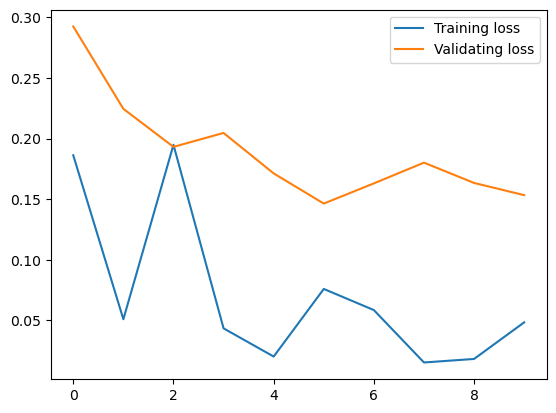

In [39]:
plt.plot([trl.detach().numpy() for trl in train_losses], label = "Training loss")
plt.plot([tsl.detach().numpy() for tsl in test_losses], label = "Validating loss")

plt.legend()
plt.show()

In [40]:
train_accuracy = [t / 600 for t in train_correct]
train_accuracy

[tensor(89.5267),
 tensor(95.3750),
 tensor(96.7583),
 tensor(97.5500),
 tensor(98.0317),
 tensor(98.3317),
 tensor(98.6500),
 tensor(98.8900),
 tensor(99.0633),
 tensor(99.1883)]

In [41]:
val_accuracy = [t / 100 for t in test_correct]
val_accuracy

[tensor(94.6500),
 tensor(96.0100),
 tensor(97.0400),
 tensor(96.8200),
 tensor(97.1300),
 tensor(97.7900),
 tensor(97.4800),
 tensor(97.3400),
 tensor(97.5900),
 tensor(97.5400)]

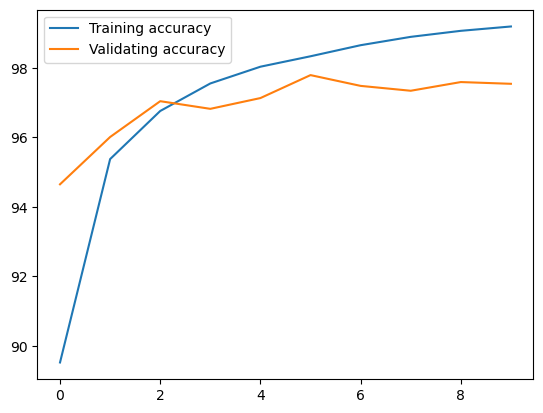

In [42]:
plt.plot(train_accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label = "Validating accuracy")

plt.legend()
plt.show()

## __Testing with new data__

In [44]:
all_data_test_load = DataLoader(test_data, batch_size = 10000, shuffle = False)

In [48]:
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in all_data_test_load:
        y_testing = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_testing.detach(), 1)[1]
        correct += (predicted == y_test).sum()


In [52]:
# total accuracy on the test dataset

correct.item() / len(test_data) * 100

97.54

In [60]:
print(predicted.view(-1))

tensor([7, 2, 1,  ..., 4, 5, 6])


In [61]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 973,    1,    5,    1,    2,    3,    8,    2,   13,    3],
       [   0,  1123,    2,    0,    0,    0,    3,    1,    1,    2],
       [   2,    1,  1004,    6,    2,    0,    1,    7,    2,    0],
       [   1,    4,    4,  985,    1,    6,    1,    2,    9,    5],
       [   0,    0,    3,    0,  964,    1,    9,    2,    5,   10],
       [   0,    1,    0,    5,    0,  872,    4,    0,    8,    1],
       [   1,    2,    1,    0,    3,    6,  930,    0,    4,    0],
       [   0,    0,    7,    3,    1,    0,    0,  1002,    5,    5],
       [   1,    3,    5,    1,    0,    3,    2,    3,  920,    2],
       [   2,    0,    1,    9,    9,    1,    0,    9,    7,  981]],
      dtype=int64)

In [62]:
confusion_matrix(predicted.flatten(), y_test.flatten())

array([[ 973,    1,    5,    1,    2,    3,    8,    2,   13,    3],
       [   0,  1123,    2,    0,    0,    0,    3,    1,    1,    2],
       [   2,    1,  1004,    6,    2,    0,    1,    7,    2,    0],
       [   1,    4,    4,  985,    1,    6,    1,    2,    9,    5],
       [   0,    0,    3,    0,  964,    1,    9,    2,    5,   10],
       [   0,    1,    0,    5,    0,  872,    4,    0,    8,    1],
       [   1,    2,    1,    0,    3,    6,  930,    0,    4,    0],
       [   0,    0,    7,    3,    1,    0,    0,  1002,    5,    5],
       [   1,    3,    5,    1,    0,    3,    2,    3,  920,    2],
       [   2,    0,    1,    9,    9,    1,    0,    9,    7,  981]],
      dtype=int64)

## __Incorrect guesses__

In [64]:
incorrect = np.array([])
for i in range(len(predicted.flatten())):
    if predicted[i] != y_test[i]:
        incorrect = np.append(incorrect,i).astype('int64')
        
# Display the number of misses
len(incorrect)

246

In [65]:
# Set up an iterator to feed batched rows
r = 10
batch = iter(np.array_split(incorrect,len(incorrect)//r+1))

Index: [ 1395  1414  1464  1494  1522  1530  1549  1553  1609  1681]
Label: [   2    9    8    7    7    8    4    9    2    3]
Guess: [   3    7    3    0    9    7    6    3    3    7]


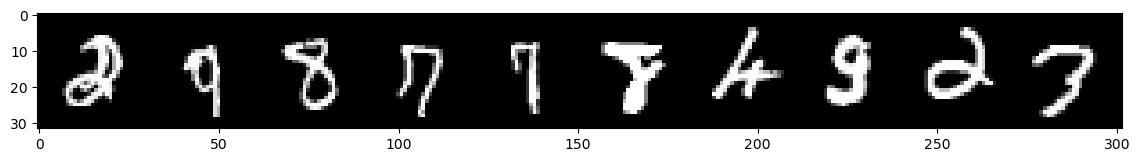

In [70]:
nextrow = next(batch)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0, torch.tensor(nextrow))
im = make_grid(images, nrow = r)
plt.figure(figsize = (14, 8))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
plt.show()